In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [ ]:


SEED = 2333
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.set_rng_state(torch.manual_seed(SEED).get_state())

def make_graph(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('base_corner')
    plt.imshow(mask)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('base_corner mask')
    plt.imshow(mask)
    plt.axis('off')

    # Add text labels below each subplot
    caption_y = -0.1  # Adjust for desired vertical position below X-axis
    caption_x1 = -0.6  # Horizontal position for subplot 1 (adjust as needed)
    caption_x2 = 0.6  # Horizontal position for subplot 2 (adjust as needed)

    caption_1 = f"{image.dtype} , shape: {image.shape}"
    caption_2 = f"{mask.dtype}, shape: {mask.shape}"
    plt.text(caption_x1, caption_y, caption_1, size=12, ha="center", transform=plt.gca().transAxes)
    plt.text(caption_x2, caption_y, caption_2, size=12, ha="center", transform=plt.gca().transAxes)

    plt.show()

strategies used {'random_crop': True, 'semantic_label_inpainting_pair': True, 'semantic_label_copy_paste_pair': True}
3378
2799
portugal-wildfire_00001232_pre_disaster.png
DATA SHOWN IN JUPYTER NOTEBOOK
base_corner minmax: (8, 200), base_corner dtype: uint8
helper_corner minmax: (8, 200), helper_corner dtype: uint8


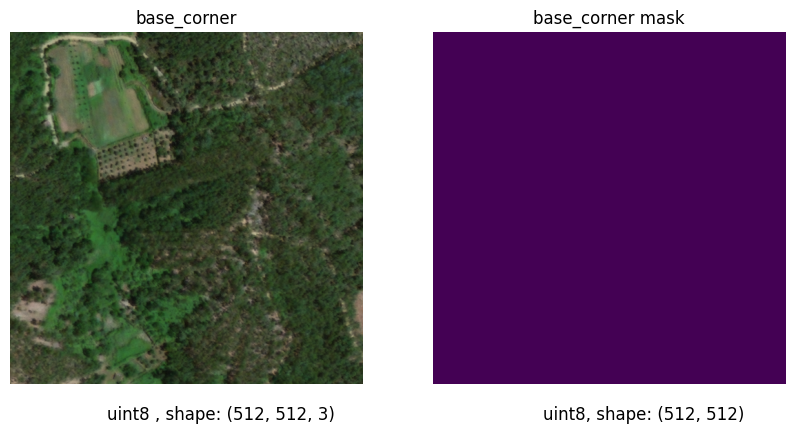

DATA SHOWN IN JUPYTER NOTEBOOK
base_corner minmax: (tensor(-1.9467), tensor(1.2031)), base_corner dtype: torch.Size([3, 512, 512])
helper_corner minmax: (tensor(-1.9638), tensor(1.0630)), helper_corner dtype: torch.Size([3, 512, 512])


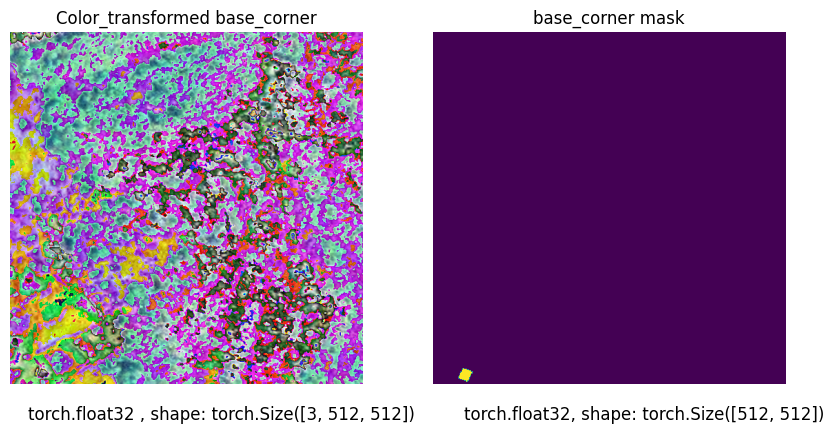

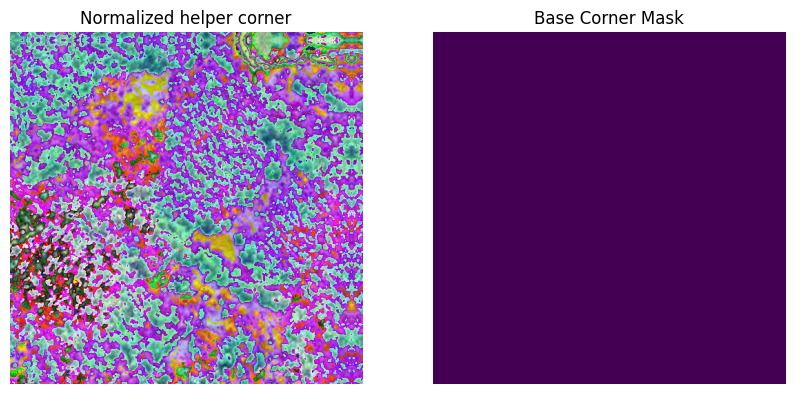

In [70]:
# Import necessary modules and classes
import ever as er
import torch
import numpy as np
import cv2
import random
from PIL import Image
from skimage.io import imread

from core import field
from core.dataset import ColorAugDataset
from torch.utils.data import ConcatDataset
from data.xview2.xview2_dataset import PreCachedXview2Building
from data.xview2.xview2_loader import PreCachedXview2BuildingLoader
from configs.trainxView2.r50_farseg_changemixin_inpainting import config
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# Load data using the configuration path and model directory
image_dir=("./xview2/tier3/images", "./xview2/train/images")
target_dir=("./xview2/tier3/targets", "./xview2/train/targets")

strategies = dict(
                random_crop=True,
                semantic_label_inpainting_pair=True,
                semantic_label_copy_paste_pair=True,
            )

print(f"strategies used {strategies}")


color_transform = config['data']['train']['params']['color_transforms']

geo_transform=config['data']['train']['params']['geo_transforms']

# Create the dataset without any changes
dataset_list = []
for im_dir, target_dir in zip(
    image_dir, target_dir
):
    dataset_list.append(PreCachedXview2Building(im_dir, target_dir, geo_transform, strategies))

dataset = ConcatDataset(dataset_list)

# Verify that the DataLoader is not empty
if len(dataset) == 2799:
    raise ValueError("The DataLoader is empty. Please check the dataset and configuration.")

# Retrieve one sample from the dataset
# 1 => empty data_set test value
# 5 => data with empty corner values (black screen)
# 25 => good filled
idx = np.random.randint(1, len(dataset))
# idx = 5

# for i in range(100):
#     x, y = dataset[i]

x, y = dataset[idx]
print(y["image_filename"])

# Show original image
# org_img = imread("./xview2/tier3/images/"+y["image_filename"])
# org_mask = imread("./xview2/tier3/targets/"+y["image_filename"].replace(".png", "_target.png"))
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('Original image')
# plt.imshow(org_img)
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.title('Full Original Mask')
# plt.imshow(org_mask)
# plt.axis('off')

#######
base_corner_np = x[:, :, :3]
helper_corner_np = x[:, :, 3:]
mask = y[field.MASK1]
mask2 = y[field.VMASK2]
#######
print("DATA SHOWN IN JUPYTER NOTEBOOK")
print(f"base_corner minmax: {base_corner_np.min(), base_corner_np.max()}, base_corner dtype: {base_corner_np.dtype}")
print(f"helper_corner minmax: {helper_corner_np.min(), helper_corner_np.max()}, helper_corner dtype: {helper_corner_np.dtype}")
# print("base_mask", mask.dtype)
# print("blended_corner", helper_corner_np.dtype)
# print("base_corner shape", helper_corner_np.shape)
# print("blended_mask", mask2.dtype)

to_pil = ToPILImage()
# Base corner Mask / Image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('base_corner')
plt.imshow(base_corner_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('base_corner mask')
plt.imshow(mask)
plt.axis('off')

# Add text labels below each subplot
caption_y = -0.1  # Adjust for desired vertical position below X-axis
caption_x1 = -0.6  # Horizontal position for subplot 1 (adjust as needed)
caption_x2 = 0.6  # Horizontal position for subplot 2 (adjust as needed)

caption_1 = f"{base_corner_np.dtype} , shape: {base_corner_np.shape}"
caption_2 = f"{mask.dtype}, shape: {mask.shape}"
plt.text(caption_x1, caption_y, caption_1, size=12, ha="center", transform=plt.gca().transAxes)
plt.text(caption_x2, caption_y, caption_2, size=12, ha="center", transform=plt.gca().transAxes)

plt.show()

# Helper corner Mask / Image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title('helper_corner')
# plt.imshow(helper_corner_np)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('helper_corner mask')
# plt.imshow(mask2)
# plt.axis('off')

# # Add text labels below each subplot
# caption_y = -0.1  # Adjust for desired vertical position below X-axis
# caption_x1 = -0.6  # Horizontal position for subplot 1 (adjust as needed)
# caption_x2 = 0.6  # Horizontal position for subplot 2 (adjust as needed)

# caption_1 = f"{helper_corner_np.dtype} , shape: {helper_corner_np.shape}"
# caption_2 = f"{mask2.dtype}, shape: {mask2.shape}"
# plt.text(caption_x1, caption_y, caption_1, size=12, ha="center", transform=plt.gca().transAxes)
# plt.text(caption_x2, caption_y, caption_2, size=12, ha="center", transform=plt.gca().transAxes)

# plt.show()



###########################################

dataset = ColorAugDataset(
                dataset,
                geo_transform=None,
                color_transform=config['data']['train']['params']['color_transforms'],
                common_transform=config['data']['train']['params']['common_transforms'],
            )


# #######
# print(f"index: {idx}")
x, y = dataset[idx]
base_corner_np = x[:3,:, :]
helper_corner_np = x[3:,:, :]
mask = y[field.MASK1]
mask2 = y[field.VMASK2]
# #######


print("DATA SHOWN IN JUPYTER NOTEBOOK")
print(f"base_corner minmax: {base_corner_np.min(), base_corner_np.max()}, base_corner dtype: {base_corner_np.shape}")
print(f"helper_corner minmax: {helper_corner_np.min(), helper_corner_np.max()}, helper_corner dtype: {helper_corner_np.shape}")


############################################
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Color_transformed base_corner')
plt.imshow(to_pil(base_corner_np))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('base_corner mask')
plt.imshow(mask)
plt.axis('off')

# Add text labels below each subplot
caption_y = -0.1  # Adjust for desired vertical position below X-axis
caption_x1 = -0.6  # Horizontal position for subplot 1 (adjust as needed)
caption_x2 = 0.6  # Horizontal position for subplot 2 (adjust as needed)

caption_1 = f"{base_corner_np.dtype} , shape: {base_corner_np.shape}"
caption_2 = f"{mask.dtype}, shape: {mask.shape}"
plt.text(caption_x1, caption_y, caption_1, size=12, ha="center", transform=plt.gca().transAxes)
plt.text(caption_x2, caption_y, caption_2, size=12, ha="center", transform=plt.gca().transAxes)

plt.show()
############################################

# # Step 4: Visualize the base corner image/mask and helper corner image/mask
to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Normalized helper corner')
plt.imshow(to_pil(helper_corner_np))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Base Corner Mask')
plt.imshow(mask2)
plt.axis('off')
plt.show()

In [ ]:
import glob
import os
from skimage.io import imread

target_dir=("./xview2/tier3/targets")
image_dir=("./xview2/tier3/images")

image_fps = sorted(
    [fp for fp in glob.glob(os.path.join(image_dir, "*.png")) if "pre" in fp]
)

target_fps =[
    os.path.join(image_dir, os.path.basename(fp.replace("_target.png", ".png")))
    for fp in image_fps
]

print(len(image_fps))
print(len(target_fps))

In [ ]:
# Import necessary modules and classes
import ever as er
import torch
import numpy as np
import cv2
import random
from PIL import Image

from core import field
from core.dataset import ColorAugDataset
from torch.utils.data import ConcatDataset
from data.xview2.xview2_dataset import PreCachedXview2Building
from data.xview2.xview2_loader import PreCachedXview2BuildingLoader
from configs.trainxView2.r50_farseg_changemixin_inpainting import config
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

target_dir=("./xview2/tier3/targets")
image_dir=("./xview2/tier3/images")

image_fps = sorted(
    [fp for fp in glob.glob(os.path.join(image_dir, "*.png")) if "pre" in fp]
)

# Extract the base filenames (without the directory and suffixes)
base_image_filenames = set(
    os.path.basename(fp).replace("_pre_disaster.png", "") for fp in image_fps
)

# Construct the target filenames
constructed_target_fps = sorted(
    os.path.join(target_dir, f"localization_{base_name.replace('_', '-')}_target.png")
    for base_name in base_image_filenames
)

# Filter the target files that exist
target_fps = [fp for fp in constructed_target_fps if os.path.isfile(fp)]

target = imread(target_fps[1])
image = imread(image_fps[1])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Helper Corner Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Helper Corner Mask')
plt.imshow(target)
plt.axis('off')
plt.show()


to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Helper Corner Image')
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from platform import python_version

print(np.random.randint(1,3))

In [ ]:
# Import strategy used
idx = 1
x, y = dataset[idx]
img = np.array(x)
mask = np.array(y[field.MASK1])
mask2 = np.array(y[field.VMASK2])

print(x.dtype)
print(mask.dtype)
print(img.dtype)

half_width = x.shape[1] // 2
base_corner_tensor = x[:3, :, :]
helper_corner_tensor = x[3:, :, :]


to_pil = ToPILImage()
# Step 3: Visuazlize the original image and mask
plt.figure(figsize=(10, 5))  # Adjust the figsize parameter to increase the size
plt.subplot(1, 2, 1)
plt.title('Full Original Image')
plt.imshow(to_pil(base_corner_tensor))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Full Original Mask')
plt.imshow(mask)
plt.axis('off')
plt.show()

# Step 4: Visualize the base corner image/mask and helper corner image/mask
to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Base Corner Image')
plt.imshow(to_pil(helper_corner_tensor))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Base Corner Mask')
plt.imshow(mask2)
plt.axis('off')
plt.show()

In [ ]:
import json
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

# Paths to your directories
image_dir = "./xview2/tier3/images"
target_dir = "./xview2/tier3/target"
labels_dir = "./xview2/tier3/labels"

# Create the target directory if it does not exist
os.makedirs(target_dir, exist_ok=True)

# Get the list of all label files
label_files = glob(os.path.join(labels_dir, "*.json"))

# Function to convert polygon coordinates from WKT to a list of (lat, lng) tuples
def wkt_to_coords(wkt):
    coords = wkt.replace('POLYGON ((', '').replace('))', '').split(', ')
    coords = [tuple(map(float, coord.split())) for coord in coords]
    return coords

# Function to convert (lat, lng) coordinates to pixel coordinates
def latlng_to_pixel(coords, width, height):
    return [(int((lng + 180) * (width / 360)), int((90 - lat) * (height / 180))) for lng, lat in coords]

# Process each label file
for label_file in label_files:
    with open(label_file, 'r') as f:
        data = json.load(f)
    
    # Derive the corresponding image file name
    image_filename = os.path.basename(label_file).replace(".json", ".png")
    image_path = os.path.join(image_dir, image_filename)
    print("Attempting to read image from:", image_path)

    
    # Read the corresponding image to get its dimensions
    if not os.path.exists(image_path):
        print(f"Image file {image_path} does not exist. Skipping.")
        continue
    
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Create a blank image for the mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Iterate through each feature (polygon) in the JSON file
    for feature in data['features']['lng_lat']:
        wkt = feature['wkt']
        
        # Extract the coordinates from the WKT string
        coords = wkt_to_coords(wkt)
        
        # Convert coordinates to pixel values
        polygon = np.array(latlng_to_pixel(coords, width, height))
        
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [polygon], 1)
    
    # Save the mask image
    mask_filename = image_filename.replace(".png", "_target.png")
    mask_filepath = os.path.join(target_dir, mask_filename)
    cv2.imwrite(mask_filepath, mask)

    print(f"Created mask for {image_filename} and saved to {mask_filepath}")

print('Masks have been created successfully.')


In [ ]:
print('Masks have been created successfully.')

IoU: 0.6650
F1 Score: 0.7988


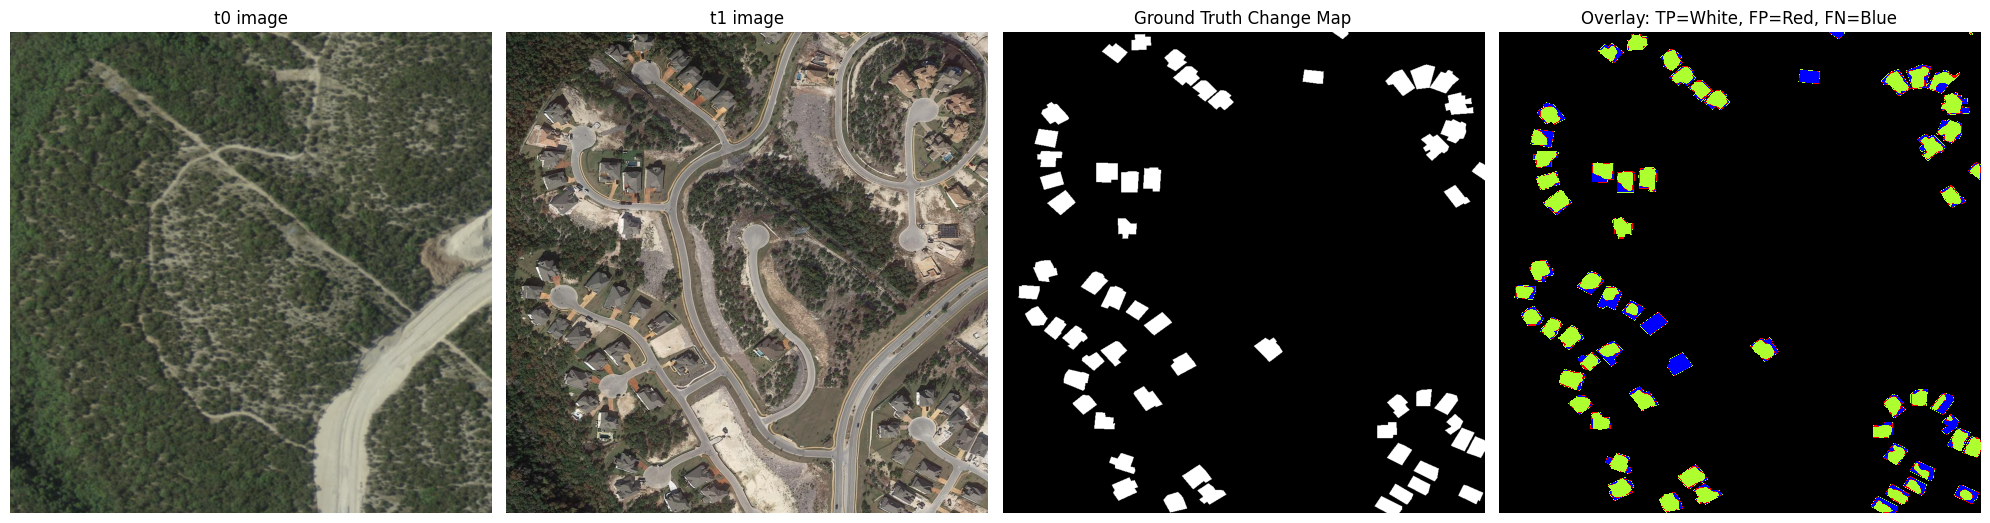

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

generated_binary  = np.array(Image.open("change_map.png"))
t0_image = np.array(Image.open("/home/stud/okuyama/original-changestar/ChangeStar/LEVIR-CD/train/A/train_118.png"))
t1_image = np.array(Image.open("/home/stud/okuyama/original-changestar/ChangeStar/LEVIR-CD/train/B/train_118.png"))
ground_truth_binary  = np.array(Image.open("/home/stud/okuyama/original-changestar/ChangeStar/LEVIR-CD/train/label/train_118.png"))

# Compute differences
true_positives = np.logical_and(generated_binary == 255, ground_truth_binary == 255)
false_positives = np.logical_and(generated_binary == 255, ground_truth_binary == 0)
false_negatives = np.logical_and(generated_binary == 0, ground_truth_binary == 255)
true_negatives = np.logical_and(generated_binary == 0, ground_truth_binary == 0)

# Overlay maps
overlay = np.zeros_like(generated_binary, dtype=np.uint8)
overlay[true_positives] = 1  # True positives in green
overlay[false_positives] = 2  # False positives in red
overlay[false_negatives] = 3  # False negatives in blue

custom_cmap = plt.cm.colors.ListedColormap(['black', (173/255, 255/255, 47/255, 1.0), 'red', 'blue'])

# Example counts (replace with actual counts)
TP = np.sum(true_positives)
FP = np.sum(false_positives)
FN = np.sum(false_negatives)

# Compute IoU
intersection = TP
union = TP + FP + FN
iou = intersection / union

# Compute Precision and Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Compute F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"IoU: {iou:.4f}")
print(f"F1 Score: {f1_score:.4f}")
    
# Plotting
plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(t0_image)
plt.title('t0 image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(t1_image)
plt.title('t1 image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(ground_truth_binary, cmap='gray')
plt.title('Ground Truth Change Map')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(overlay, cmap=custom_cmap , vmin=0, vmax=3)
plt.title('Overlay: TP=White, FP=Red, FN=Blue')
plt.axis('off')

plt.tight_layout()
plt.show()